In [243]:
import json
import csv
import pandas as pd
import numpy as np
import os
from collections.abc import Sequence

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
%matplotlib inline

from sklearn import preprocessing
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Convolution2D
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
import h5py




from collections import Counter
from datetime import datetime

pd.options.display.max_columns = 200

In [247]:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

### HELPER FUNCTIONS ###

def create_hdf5_for_caffe(hdf5_filename, txt_filename, data, labels, name=None, descr=None, shuffle=False):
    print('hello')
        
def hdf5_to_txt(txt_filename , hdf5File):
    with open(txt_filename, mode='w') as txt_file:
        txt_file.writelines([hdf5File])
        
def create_attack_collumn(df):
    le = MyLabelEncoder()
    
    attackList = []
    outcomelist = df['outcome'].tolist()
    for item in outcomelist:
        if str(item) == 'normal.':
            attackList.append("notAttack")
        else:
            attackList.append("Attack")
    
    df['attack'] = attackList
    
    le.fit(['notAttack','Attack'])
    df['attack'] = le.transform(df['attack'])
    
    return le.classes_
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
def to_xy_multiClass(df, target):
    result = []
    for x in df.columns:
        if x not in target:
            result.append(x)
    dummies = pd.get_dummies(df[target])
    return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
        

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
    
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [248]:
# Make a pandas dataframe with csv file
df = pd.read_csv('network_intrusion_data.csv', encoding="utf-8")
df.columns = ['duration', 'protocol_type', 'service', 'flag','src_bytes', 'dst_bytes','land', 'wrong_fragment', 
              'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
              'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 
              'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
              'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
              'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
              'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
              'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']

# Drop redundant records
df.drop_duplicates(subset=None, inplace=True)


# Drop records with missing values
df.dropna()

#Custom binary encode to create attack
values = create_attack_collumn(df)




In [249]:
#encode the input for categorical data
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_text_dummy(df, 'land')
encode_text_dummy(df, 'logged_in')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
#encode_text_dummy(df, 'outcome')

#normalize numeric data
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
df.dropna()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,attack,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,0,-0.004261,-0.039036,0,0,0,0,0,0,0,0,0,0,0,0,-0.661636,-0.163049,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.639490,-0.967055,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
1,0,-0.004263,-0.025041,0,0,0,0,0,0,0,0,0,0,0,0,-0.661636,-0.163049,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.538579,-0.879882,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
2,0,-0.004272,-0.025041,0,0,0,0,0,0,0,0,0,0,0,0,-0.681569,-0.228118,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.437668,-0.792710,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
3,0,-0.004273,-0.013612,0,0,0,0,0,0,0,0,0,0,0,0,-0.681569,-0.228118,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.336758,-0.705537,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
4,0,-0.004273,-0.013612,0,0,0,0,0,0,0,0,0,0,0,0,-0.681569,-0.228118,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.235847,-0.618364,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,-0.004222,-0.016095,0,0,0,0,0,0,0,0,0,0,0,0

In [296]:
#CNN FOR DATASET

hdf_file = h5py.File('best_weights.hdf5', 'w')

hdf_file.close()

In [297]:
# Encode to a 2D matrix for training
x,y = to_xy_multiClass(df,['attack','outcome'])


# Split into train/test for Fully Connected Network
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(116468, 121) (29117, 121)
(116468, 24) (29117, 24)


In [302]:

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model = Sequential()
model.add(Dense(500, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(250))
model.add(Dense(y_train.shape[1],activation='softmax'))

opt = keras.optimizers.Adam(lr=.001)

model.compile(loss='categorical_crossentropy', optimizer=opt )

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

# load weights from best model
model.load_weights('best_weights.hdf5') 


Epoch 1/100
3640/3640 - 4s - loss: 1281645.5000 - val_loss: 6327113.5000
Epoch 2/100
3640/3640 - 4s - loss: 21578918.0000 - val_loss: 52257304.0000
Epoch 3/100
3640/3640 - 4s - loss: 95273160.0000 - val_loss: 180573504.0000
Epoch 4/100
3640/3640 - 4s - loss: 209716544.0000 - val_loss: 340023616.0000
Epoch 5/100
3640/3640 - 4s - loss: 364696512.0000 - val_loss: 541969792.0000
Epoch 6/100
3640/3640 - 4s - loss: 522476032.0000 - val_loss: 764518528.0000
Epoch 00006: early stopping


In [301]:
model.summary()
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)


print("Final accuracy: {}".format(score))


Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 121)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 128)               15616     
_________________________________________________________________
dense_241 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_242 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_243 (Dense)            (None, 24)                792       
Total params: 26,744
Trainable params: 26,744
Non-trainable params: 0
_________________________________________________________________
Final accuracy: 0.6893567331799293


[[  797     0 13235     0   427     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [ 4394    91     0     1 17412    40]
 [    0     0     0     0     0     0]]
Plotting confusion matrix


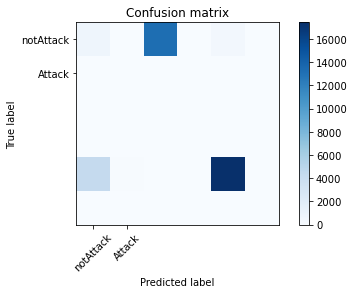

              precision    recall  f1-score   support

           0       0.15      0.06      0.08     14459
           7       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.98      0.79      0.88     21938
          22       0.00      0.00      0.00         0

    accuracy                           0.50     36397
   macro avg       0.19      0.14      0.16     36397
weighted avg       0.65      0.50      0.56     36397



In [258]:

# Compute confusion matrix

cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, values)
plt.show()

print(classification_report(y_true, pred))

In [304]:
#CNN FOR DATASET

hdf_file = h5py.File('cnn_best_weights.hdf5', 'w')


hdf_file.close()

In [305]:
encode_text_dummy(df, 'outcome')

In [306]:

# Encode to a 2D matrix for training
x,y = to_xy(df,'attack')

x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.2, random_state=45)

print(x_train)

[[ 0.         -0.00423028 -0.01940079 ...  0.          0.
   0.        ]
 [ 0.         -0.00439233 -0.04702783 ...  0.          0.
   0.        ]
 [ 0.         -0.00420116 -0.00705085 ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00422698 -0.02934982 ...  0.          0.
   0.        ]
 [ 0.         -0.00439233 -0.04702783 ...  0.          0.
   0.        ]
 [ 0.         -0.00433465 -0.04461046 ...  0.          0.
   0.        ]]


In [307]:

# define input image dimensions
img_rows, img_cols = 1, 144

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# convert to float32 for normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [231]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
input_shape = (img_rows, img_cols, 1)

(116468, 1, 144, 1) (29117, 1, 144, 1)
(116468, 2) (29117, 2)


In [308]:
#CNN model
cnnModel = Sequential()
cnnModel.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
cnnModel.add(MaxPooling2D(pool_size=(1,2)))
cnnModel.add(Flatten())
cnnModel.add(Dense(100))
cnnModel.add(Dropout(0.5))
cnnModel.add(Dense(2))
cnnModel.add(Activation('softmax'))
cnnModel.compile(loss='categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

cnnModel.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 142, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 71, 64)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4544)              0         
_________________________________________________________________
dense_247 (Dense)            (None, 100)               454500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 2)                 202       
_________________________________________________________________
activation_2 (Activation)    (None, 2)               

In [309]:

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

checkpointer = ModelCheckpoint(filepath="cnn_best_weights.hdf5", verbose=0, save_best_only=True) # save best model


In [310]:
cnnModel.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=1,epochs=2)
cnnModel.load_weights('cnn_best_weights.hdf5')

Epoch 1/2
3640/3640 [==============================] - 12s 3ms/step - loss: 1.4940 - accuracy: 0.9287 - val_loss: 0.3310 - val_accuracy: 0.9711
Epoch 2/2
3640/3640 [==============================] - 13s 3ms/step - loss: 0.8985 - accuracy: 0.9675 - val_loss: 0.4196 - val_accuracy: 0.9743


In [311]:
score = cnnModel.evaluate(x_test,y_test)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

910/910 [==============================] - 1s 1ms/step - loss: 0.3310 - accuracy: 0.9711
Test loss: 0.3309987783432007
Test accuracy: 0.9711165428161621


[[17552    21]
 [  820 10724]]
Plotting confusion matrix


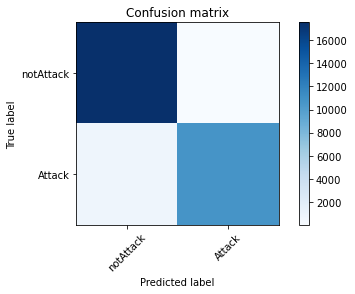

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17573
           1       1.00      0.93      0.96     11544

    accuracy                           0.97     29117
   macro avg       0.98      0.96      0.97     29117
weighted avg       0.97      0.97      0.97     29117



In [312]:
pred = cnnModel.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_true, pred)



cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, values)
plt.show()

print(classification_report(y_true, pred))